# Demo - Siren (PyTorch)

In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root, local
root = here(project_files=[".root"])
local = here(project_files=[".local"])

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [2]:
from pathlib import Path
import argparse
import wandb
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# # Ensure TF does not see GPU and grab all GPU memory.
# import tensorflow as tf
# tf.config.set_visible_devices([], device_type='GPU')

# os.environ["JAX_PLATFORM_NAME"] = "CPU"
# # ENSURE JAX DOESNT PREALLOCATE
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = str(False)

import jax
import jax.random as jrandom
import jax.numpy as jnp
import equinox as eqx
from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from models.siren_torch import add_model_args
from loss import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizer import add_optimizer_args, get_optimizer
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.argparse import add_argparse_args

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import loguru

### Arguments

In [5]:
parser = argparse.ArgumentParser()

# logger
parser = add_logger_args(parser)

# data
parser = get_data_args(parser)

# preprocessing, feature transform, split
parser = add_preprocess_args(parser)
parser = add_feature_args(parser)
parser = add_split_args(parser)

# model, optimizer, loss
parser = add_model_args(parser)
parser = add_optimizer_args(parser)
parser = add_loss_args(parser)
parser = add_argparse_args(Trainer, parser)

# postprocessing, metrics
parser = add_postprocess_args(parser)
parser = add_eval_args(parser)

# parse args
args = parser.parse_args([])

# # jeanzay specific
# args.train_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/train/"
# args.ref_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/ref/"
# args.test_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/test/"
# args.log_dir = "/gpfswork/rech/cli/uvo53rl/logs"

# training args
# args.log_dir = 
args.batch_size = 4096
args.n_epochs = 5

# model args
args.model = "siren"
args.activation = "sine"
args.julian_time = True
args.framework = "pytorch"

# smoke test
args.smoke_test = True

# logging stuff
args.project = "nerf4ssh"
args.wandb_mode = "disabled"
args.wandb_resume = False
# ige/nerf4ssh/kx2nr6qb
args.id = None # "mikf2n1v" # "2uuq7tks" "kx2nr6qb"
# args.entity = "ige"


### Logger


In [6]:
# init wandb logger
wandb_logger = WandbLogger(
    id=args.id,
    config=args,
    mode=args.wandb_mode,
    project=args.project,
    entity=args.entity,
    dir=args.log_dir,
    resume=args.wandb_resume,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


### Load Data

In [47]:
%%time

# load data
data = load_data(args)

100%|██████████| 6/6 [00:00<00:00, 45.92it/s]


CPU times: user 280 ms, sys: 376 ms, total: 656 ms
Wall time: 676 ms


In [48]:
# preprocess data
data = preprocess_data(data, args)

In [49]:
# feature transformation
data, scaler = feature_transform(data, args)

In [50]:
data.attrs["input_cols"]

['longitude', 'latitude', 'time']

In [51]:
# split data
xtrain, ytrain, xvalid, yvalid = split_data(data, args)

args.in_dim = xtrain.shape[-1]
args.n_train = xtrain.shape[0]
args.n_valid = xvalid.shape[0]

wandb_logger.log_hyperparams(
    {
        "in_dim": args.in_dim,
        "n_train": args.n_train,
        "n_valid": args.n_valid,
    }
)

In [52]:
args.n_train, args.n_valid

(1611084, 179010)

In [54]:
data[data.attrs["input_cols"]].describe()

,longitude,latitude,time
count,1.790094e+06,1.790094e+06,1.790094e+06
mean,9.931211e-02,-1.456369e-01,-2.934260e-02
std,5.638133e-01,5.215216e-01,5.806831e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-3.652177e-01,-5.852729e-01,-5.627976e-01
50%,1.326643e-01,-1.742332e-01,1.634461e-04
75%,5.935011e-01,2.463873e-01,4.528359e-01
max,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
describe

### Dataset

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

In [12]:
class PointsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        
        return X, y

In [13]:
# initialize dataset
ds_train = PointsDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
ds_valid = PointsDataset(torch.Tensor(xvalid), torch.Tensor(yvalid))
# initialize dataloader
# initialize dataloader
dl_train = DataLoader(
    ds_train, 
    batch_size=args.batch_size, 
    shuffle=True, 
    pin_memory=False,
    num_workers=args.num_workers
)
dl_valid = DataLoader(
    ds_valid, 
    batch_size=args.batch_size, 
    shuffle=False, 
    pin_memory=False,
    num_workers=args.num_workers,
)

### Model

In [14]:
from ml4ssh._src.models_torch.siren import SirenNet

In [15]:
model = SirenNet(
    dim_in=3,
    dim_hidden=args.hidden_dim,
    dim_out=ytrain.shape[1], 
    num_layers=args.n_hidden, 
    w0=args.w0,
    w0_initial=args.w0_initial,
    use_bias=True,
    final_activation=None
)
    

In [16]:
args.w0, args.w0_initial

(1.0, 30.0)

### Training

In [17]:
import torch
from torch import nn


In [18]:
import pytorch_lightning as pl

class LearnerPoints(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.loss = nn.MSELoss(reduction="mean")

    def forward(self, x):
        return self.model(x)
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        
        
        x, y = batch
        pred = self.model(x)
        
        return pred

    def training_step(self, batch, batch_idx):
        x, y = batch
        # loss function
        pred = self.model(x)
        loss = self.loss(pred, y)
        
        self.log("train_loss", loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        # loss function
        pred = self.model(x)
        loss = self.loss(pred, y)
        
        self.log("valid_loss", loss)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=args.learning_rate)

In [19]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

callbacks = [
    ModelCheckpoint(
        dirpath = f"{wandb_logger.experiment.dir}/checkpoints",
        monitor="valid_loss",
        mode="min",
        save_top_k=1,
        save_last=True,
    ),
    EarlyStopping(monitor="valid_loss", mode="min", patience=10),
    
]

In [20]:
# initialize trainer
learn = LearnerPoints(model)

In [21]:
from pytorch_lightning import seed_everything
seed_everything(123)

Global seed set to 123


123

In [22]:
# initialize trainer
trainer = pl.Trainer(
    min_epochs=args.min_epochs, 
    max_epochs=args.n_epochs, 
    gpus=args.gpus, 
    enable_progress_bar=True, 
    logger=wandb_logger,
    callbacks=callbacks,
)

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(learn, train_dataloaders=dl_train, val_dataloaders=dl_valid)


  | Name  | Type     | Params
-----------------------------------
0 | model | SirenNet | 1.3 M 
1 | loss  | MSELoss  | 0     
-----------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.263     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Save models

In [24]:
# callbacks[0].best_model_path

In [25]:
# torch.save(model.state_dict(), 'save/to/path/model.pth'﻿)

In [26]:
wandb_logger.experiment.dir

'./wandb/run-20220604_153418-27twdkir/files'

In [27]:
# objects
path_scaler = "scaler.pickle"

# models to save
save_object(scaler, path_scaler)

# save with wandb
wandb_logger.experiment.save(str(path_scaler))

['./wandb/run-20220604_153418-27twdkir/files/scaler.pickle']

### Load Models (Optional)

In [28]:
# # if args.server == "jz":
# # get id (from this run or a run you can set)
# run_id = wandb.run.id

# # initialize api
# api = wandb.Api()

# # get run
# run = api.run(f"{args.entity}/{args.project}/{run_id}")

# # download the files
# files = [
#     "scaler.pickle", 
#     "model.pickle"
# ]

# for ifile in files:
    
#     run.file(ifile).download(replace=True)

In [53]:
# model = load_object("./model.pickle")
# scaler = load_object("./scaler.pickle")

### PostProcessing

In [55]:
df_grid = generate_eval_data(args)

df_grid.describe()

,longitude,latitude,vtime
count,2664.000000,2664.000000,2664.000000
mean,300.000000,38.000000,213.500000
std,3.416292,3.416292,106.820098
min,295.000000,33.000000,31.000000
25%,297.000000,35.000000,121.000000
50%,300.000000,38.000000,213.500000
75%,303.000000,41.000000,306.000000
max,305.000000,43.000000,396.000000


In [56]:
df_pred = feature_transform(df_grid.copy(), args, scaler=scaler)
df_pred.describe()

['longitude', 'latitude', 'time']


,longitude,latitude,time,vtime
count,2.664000e+03,2664.000000,2664.000000,2664.000000
mean,-2.666668e-07,0.000003,0.002343,213.500000
std,2.277529e-01,0.227754,0.501610,106.820098
min,-3.333338e-01,-0.333332,-0.854648,31.000000
25%,-2.000004e-01,-0.199998,-0.432022,121.000000
50%,-2.666668e-07,0.000003,0.002343,213.500000
75%,1.999999e-01,0.200003,0.436709,306.000000
max,3.333333e-01,0.333337,0.859335,396.000000


In [57]:
df_grid.describe()

,longitude,latitude,vtime
count,2664.000000,2664.000000,2664.000000
mean,300.000000,38.000000,213.500000
std,3.416292,3.416292,106.820098
min,295.000000,33.000000,31.000000
25%,297.000000,35.000000,121.000000
50%,300.000000,38.000000,213.500000
75%,303.000000,41.000000,306.000000
max,305.000000,43.000000,396.000000


In [58]:
df_pred = df_pred[df_pred.attrs["input_cols"]]

In [59]:
df_pred.head()

,longitude,latitude,time
0,-0.333334,-0.333332,-0.854648
1,-0.333334,-0.333332,-0.831169
2,-0.333334,-0.333332,-0.807689
3,-0.333334,-0.333332,-0.784210
4,-0.333334,-0.333332,-0.760731


In [60]:
df_pred = df_pred.values

In [61]:
# initialize dataset
ds_test = PointsDataset(torch.Tensor(df_pred), torch.Tensor(df_pred))
# initialize dataloader
dl_test = DataLoader(
    ds_test, 
    batch_size=32, 
    shuffle=False, 
    pin_memory=True
)

NameError: name 'PointsDataset' is not defined

In [33]:
predictions = trainer.predict(learn, dataloaders=dl_test, return_predictions=True)


/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 394it [00:00, ?it/s]

In [34]:
predictions = torch.cat(predictions)

In [35]:
df_grid["pred"] = predictions.numpy()

In [36]:
wandb_logger.log_hyperparams(
    {
        "n_test": df_pred.shape[0],
    }
)

In [37]:
ds_oi = postprocess_data(df_grid, args)

/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/si

In [38]:
ds_oi

<xarray.Dataset>
Dimensions:    (latitude: 6, longitude: 6, time: 74)
Coordinates:
  * latitude   (latitude) float64 33.0 35.0 37.0 39.0 41.0 43.0
  * longitude  (longitude) float64 295.0 297.0 299.0 301.0 303.0 305.0
  * time       (time) datetime64[ns] 2017-01-01 2017-01-06 ... 2018-01-01
Data variables:
    index      (latitude, longitude, time) int64 0 1 2 3 ... 2660 2661 2662 2663
    vtime      (latitude, longitude, time) float64 31.0 36.0 ... 391.0 396.0
    pred       (latitude, longitude, time) float32 0.01536 -0.2091 ... 0.3708
    ssh        (latitude, longitude, time) float64 0.615 0.3906 ... 0.1993

In [39]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)

wandb_logger.log_metrics(
    {
        "model_rmse_mean": rmse_metrics[0],
        "model_rmse_std": rmse_metrics[1],
        "model_nrmse_mean": rmse_metrics[2],
        "model_nrmse_std": rmse_metrics[3],
    }
)

print(rmse_metrics)

RMSE (Mean): 0.310
RMSE (Std): 0.078
NRMSE (Mean): 0.479
NRMSE (Std): 0.271
CPU times: user 384 ms, sys: 12 ms, total: 396 ms
Wall time: 396 ms


In [40]:
psd_metrics = get_psd_metrics(ds_oi, args)
print(psd_metrics)

wandb_logger.log_metrics(
    {
        "resolved_scale": psd_metrics.resolved_scale,
    }
)

Resolved Scale: 901588192310354.000 (km)


### Figures

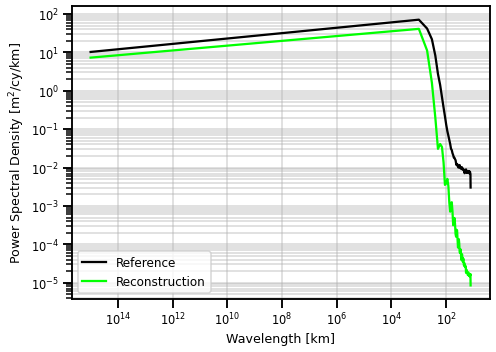

In [41]:
fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)


wandb_logger.experiment.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

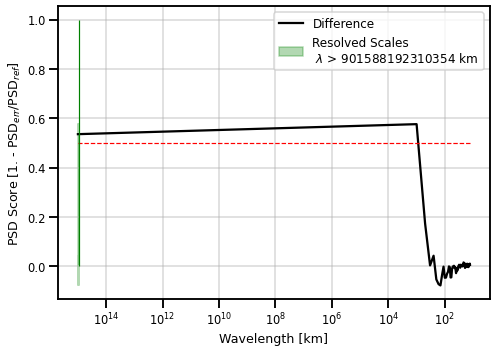

In [42]:
fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

wandb_logger.experiment.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)

### Movies

In [43]:
wandb_logger.experiment.finish()

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
model_nrmse_mean,▁
model_nrmse_std,▁
model_rmse_mean,▁
model_rmse_std,▁
resolved_scale,▁
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
valid_loss,█▄▂▁▁
epoch,4
model_nrmse_mean,0.47877


In [40]:
# save_path = wandb.run.dir #Path(root).joinpath("experiments/dc_2021b")

In [41]:
# import hvplot.xarray


# ds_oi.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

In [42]:
# create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)

<!-- ![](wandb/run-20220601_174733-kx2nr6qb/files/movie_pred.gif) -->

In [43]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh, f"pred", "time", cmap="viridis", file_path=save_path)


In [44]:
# wandb.log(
#     {
#         "predictions_gif": wandb.Image(f"{save_path}/movie_pred.gif"),
#     }
# )

### Gradients

In [45]:
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [46]:
# ds_oi.ssh_grad.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="Spectral_r")

In [47]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_grad.isel(time=slice(50,60)), f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_grad, f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)

In [48]:
# wandb.log(
#     {
#         "predictions_grad_gif": wandb.Image(f"{save_path}/movie_pred_grad.gif"),
#     }
# )

### Laplacian

In [49]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [50]:
# ds_oi.ssh_lap.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="RdBu_r")

In [51]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_lap.isel(time=slice(50,60)), f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_lap, f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)


In [52]:
# wandb.log(
#     {
#         "predictions_laplacian_gif": wandb.Image(f"{save_path}/movie_pred_lap.gif"),
#     }
# )